# Introduction

This notebook should serve as a tutorial of the aLFA framework. We analyze several components of a two-grid method to solve the linear system of equations $Ax=b$, where $A$ corresponds to the two-dimensional Laplacian discretized on an equidistant rectangular lattice.

This notebook is structured as follows. 
1. We define the underyling linear operator: The second order approximation of the two-dimensional Laplacian $L$ obtained via finite central differences (5-point stencil). We further compute its spectrum.
2. We show the connection of the operator $L$ to the system matrix $A$.
3. We introduce and analyze the Jacobi-method.
4. We define the coarse grid correction. 
5. We analyze the two-grid method using the Jacobi-method as a smoother.
6. We introduce the lexicographic Gauss-Seidel and red-black Gauss-Seidel smoother and analyze the corresponding two-grid method. 
7. We use this framework to prototype an actual two-grid method.


This Jupyter Notebook is split into multiple cells. Study this notebook from top to bottom. Don't forget to execute each cell before you jump to the next one. 

##### If you study this notebook for the first time, I would recommend that you dont change the parameter h and N=1/h.


#### If you access this notebook on gitlab, latex/math is not rendered correctly. You should run this notebook on your own machine.

In [1]:
# importing required packages.
import alfa
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

# The discretized Laplacian in 2D  
We are going to define the 2D discretized Laplacian $L:\mathcal{L}(\mathbb{L}^s(\mathcal{A})) \rightarrow \mathcal{L}(\mathbb{L}^s(\mathcal{A}))$ on an equidistant rectangular lattice. Thus, $\mathbb{L}^s(\mathcal{A})$ describes the underlying structure of the domain and codomain of the operator $L$.

## Definition of the underlying lattice structure
First, we need to define a basis of the underlying translational-invariance: an equidistant rectangular lattice is given by 
$$\mathcal{A} = \frac{1}{h}\left[\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right] = \left[\begin{matrix} \mathcal{a}_1 & \mathcal{a}_2\end{matrix}\right].$$
The lattice generated by $\mathcal{A}$ is the set $\mathbb{L}(\mathcal{A}) = \mathcal{A}\mathbb{Z}^2 = \{x = \alpha_1\mathcal{a}_1 + \alpha_2\mathcal{a}_2 \ : \ \alpha_1,\alpha_2 \in \mathbb{Z}\}$

The class alfa.Lattice corresponds to $\mathbb{L}(\mathcal{A})$ and is initialized with the matrix $\mathcal{A}$.

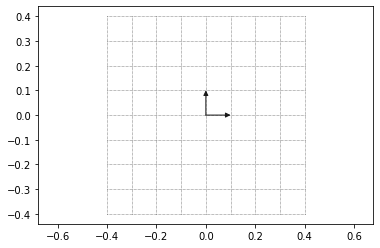

In [2]:
h = .1  # define h.
A = h*np.eye(2)  # 2x2 identity matrix scaled with h
LA = alfa.Lattice(A)  # initialize the lattice

# a plot of a section of the lattice. Black arrows correspond to the primitive vectors a_1 and a_2
LA.plot_lattice()
plt.axis('equal');

# help(alfa.Lattice) # uncomment to inspect the corresponding documentation

## Definition of the domain and codomain of the operator $L$
The structure element $s$ of $\mathbb{L}^s(\mathcal{A})$ corresponds of the location of the unknowns. We can simply choose $s=(s_1)$, where $s_1=(0,0)$, such that the crystal points coincide with the lattice structure.

The class alfa.Crystal is derived from alfa.Lattice. It is used to represent both crystals corresponding to the domain and codomain of an operator. We initialize it with alfa.Crystal(A,[s_domain, s_codomain]), where s_domain corresponds to the structure element of the domain, and s_codomain corresponds to the structure element of the codomain. (In our case we have s_domain = s_codomain = $s$):


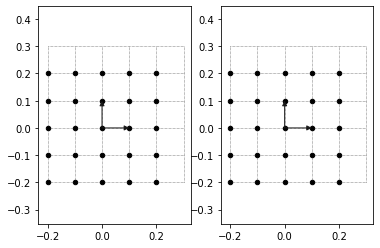

In [3]:
s_domain = np.asarray([[0, 0]])
s_codomain = np.asarray([[0, 0]])
C = alfa.Crystal(A, [s_domain, s_codomain])

# a plot of (sections of) both defined crystals, LEFT: L^{s_domain}(A) and RIGHT: L^{s_codomain}(A).
C.plot_crystal()  # black arrows correspond to the primitive vectors a_1 and a_2

# help(alfa.Crystal) # uncomment to inspect the corresponding documentation

## Initializing the operator $L$

As we have defined the underlying domain and codomain of our operator, we can initialize the multiplication operator $L$.

This class represents a multiplication operator corresponding to 
$$(Lf)(x) = \sum_{y \in \mathbb{Z}^\text{d}  } m_L^{y} \cdot f(x+\mathcal{A}y),$$ 
for all $x \in \mathbb{L}(\mathcal{A})$, where $d=2$ is the dimensionality. Note, that the position of the operator is given in fractional coordinates, not in cartesian coordinates $\mathcal{A}y$, such that $y$ is always integral.

In [4]:
L = alfa.Operator(C)

# help(alfa.Operator) # uncomment to inspect the corresponding documentation

### Adding the multipliers of $L$
We call the method L.add_multiplier(m_L^{y} , y) to define the discretized Laplacian. As the structure elements of the domain and codomain are both $1$-dimensional, the matrices m_L^{y} are of size $1\times 1$. 

The multipliers are then saved within a list L.m which is lexicographically ordered with respect to the position y. 

0th Multiplier of L: m_L^{ [-1  0] }: [[-100.+0.j]]
1th Multiplier of L: m_L^{ [ 0 -1] }: [[-100.+0.j]]
2th Multiplier of L: m_L^{ [0 0] }: [[400.+0.j]]
3th Multiplier of L: m_L^{ [0 1] }: [[-100.+0.j]]
4th Multiplier of L: m_L^{ [1 0] }: [[-100.+0.j]]


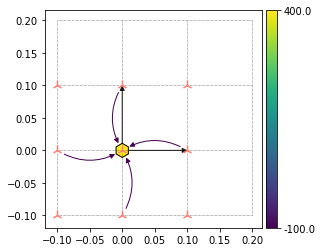

In [5]:
L.add_multiplier(np.eye(1)*4/(h*h), np.array([0, 0]))
L.add_multiplier(-np.eye(1)/(h*h), np.array([1, 0]))
L.add_multiplier(-np.eye(1)/(h*h), np.array([-1, 0]))
L.add_multiplier(-np.eye(1)/(h*h), np.array([0, 1]))
L.add_multiplier(-np.eye(1)/(h*h), np.array([0, -1]))


# accessing the multipliers of L:
for i in range(len(L.m)):
    print(
        str(i) + "th Multiplier of L: m_L^{",  L.m[i].pos,  "}:",  L.m[i].matrix)


# plot of the constructed operator.
L.plot()

## Computing the spectrum of $L$

Given a dictionary of operators $X=\{'L1':L1, 'L2':L2\}$ and a composition function $f$ (which maps $X \mapsto f(X)$), the class alfa.Operator_Composition is used to compute the spectrum of $f(X)$. The function $f$ needs to be a string which is going to be evaluated: Within the string $f$, dictionary keys must be given in single quotation marks, e.g., $f =$ "'L1'+'L2'" is used to analyze $f(X) = X['L1']+X['L2']$.

We are now going to compute the spectrum of the discretized Laplacian $L$ with this class, i.e., we have $X=['L':L]$ and $f$ the Identity ($f=$"'L'") such that $X \mapsto X['L']$

In the initialization of alfa.Operator_Composition all operators 'L' of the dictionary $X$ are rewritten with respect to a shared translational invariance $\mathbb{L}(\mathcal{C})$ and the structure elements $s_\text{domain}$ and $s_\text{codomain}$ are normalized, i.e. they are shifted into $\mathcal{C}[0,1)^d$ and sorted lexicographically.

Once alfa.Operator_Composition is initialized, we can discretize the frequency space. We do so, by splitting $[0,1)^\text{d}$ into $N^d$ equidistant points to get a discretization of the primitive cell of the dual lattice $\mathcal{A}^{-T}[0,1)^\text{d}$.

After that, we can compute the spectrum of $(f(X))_k$ via the symbols of the individual operators $L_k$ with respect to the wavevectors $k$ of the discretized primitive cell $\mathcal{A}^{-T}[0,1)^\text{d}$ with the function compute_spectrum(). 

The computed spectrum corresponds to the complete spectrum of the operator 
$$ L:\mathcal{L}(T_{\mathcal{A}, \mathcal{A}\cdot N}) \rightarrow \mathcal{L}(T_{\mathcal{A}, \mathcal{A}\cdot N}) \text{ defined on the torus } T_{\mathcal{A}, \mathcal{A}\cdot N} = \mathbb{L}(A) /  \mathbb{L}(\mathcal{A}\cdot N).$$


This discretization and the computed eigenvalues are saved in a pandas.DataFrame. $(k_0, k_1)$ corresponds to the discretization of $[0,1)^\text{2}$, whereas $(dAk_0, dAk_1)$ corresponds to the discretization of $\mathcal{A}^{-T}[0,1)^\text{2}$.


In [6]:
# help(alfa.Operator_Composition) # uncomment to inspect the corresponding documentation

   k_0  k_1  dAk_0  dAk_1          eig_0
0  0.0  0.0    0.0    0.0             0j
1  0.0  0.1    0.0    1.0   (38.1966+0j)
2  0.0  0.2    0.0    2.0  (138.1966+0j)
3  0.0  0.3    0.0    3.0  (261.8034+0j)
4  0.0  0.4    0.0    4.0  (361.8034+0j)
5  0.0  0.5    0.0    5.0       (400+0j)
6  0.0  0.6    0.0    6.0  (361.8034+0j)
7  0.0  0.7    0.0    7.0  (261.8034+0j)
8  0.0  0.8    0.0    8.0  (138.1966+0j)
9  0.0  0.9    0.0    9.0   (38.1966+0j)


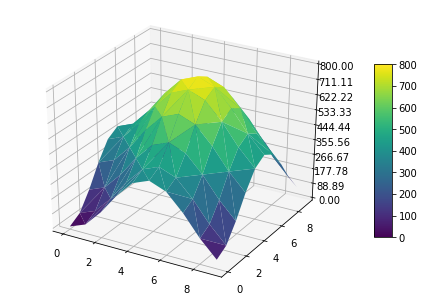

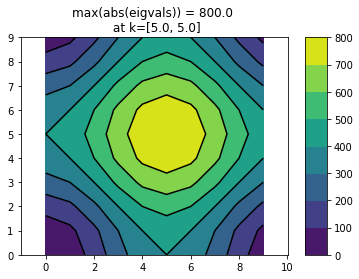

In [7]:
N = 10  # = 1/h. Increase to get a finer discretization.
# Within this function Algorithm B.5 of aLFA_Article is executed
L_opcomp = alfa.Operator_Composition({'L': L}, "'L'")
L_opcomp.discretize_frequency_space(N)
L_opcomp.compute_spectrum()

# print rows [0:10] of the dataframe 'L_opcomp.df' (It has N^2 rows in total.)
print(L_opcomp.df.iloc[0:10])

# 3D - Print the (absolute part of the) spectrum
plt.figure()
L_opcomp.plot_spectrum_3d()

# contour plot of the (absolute part of the) spectrum
plt.figure()
L_opcomp.plot_spectrum()

# Obtaining a system matrix $A$ from a multiplication operator $L$

We can obtain the system matrix $A$ corresponding to the a discretization of the Laplacian on the unit square [0,1]^2 with periodic boundary conditions in two steps.

### Step 1
We rewrite $L$ with respect to the sublattice $\mathbb{L}(\mathcal{Z}) \subset \mathbb{L}(\mathcal{A})$ with $\mathcal{Z}=\left(\begin{matrix} 1 & 0 \\ 0 & 1 \end{matrix}\right)$.

Due to the fact that we find $1/h^2 = 100$ lattice points in $Z[0,1)^2 \cap \mathbb{L}(\mathcal{A}) =: \tilde{s}$, we obtain an operator 
$$\tilde{A}:\mathcal{L}(\mathbb{L}^{\tilde{s}}(\mathcal{Z})) \rightarrow \mathcal{L}(\mathbb{L}^{\tilde{s}}(\mathcal{A})) \text{ with } (\tilde{A} g)(x) =  \sum_{y \in \mathbb{Z}^\text{d}  } m_{\tilde{A}}^{y} \cdot g(x+\mathcal{Z}y), \quad m_{\tilde{A}} \in \mathbb{C}^{100\times 100}$$


The first 13 elements of the structure element of the domain of the operator Aop: 
  [[0.  0. ]
 [0.  0.1]
 [0.  0.2]
 [0.  0.3]
 [0.  0.4]
 [0.  0.5]
 [0.  0.6]
 [0.  0.7]
 [0.  0.8]
 [0.  0.9]
 [0.1 0. ]
 [0.1 0.1]]
We find 100 lattice points L(A) in Z[0,1)^2


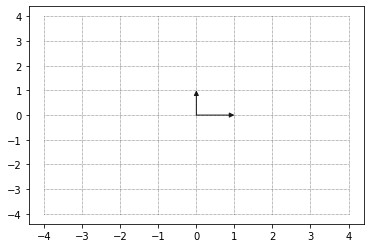

In [8]:
tA = L.wrt_lattice(alfa.Lattice(np.eye(2)))  # Algorithm B.4 of aLFA_Article
# Algorithm B.2 of aLFA_Article. The normalization does two things. 1. The structure element is shifted into Z[0,1)^2 ; 2. It sorts the structure element lexicographically.
tA.normalize()

print("The first 13 elements of the structure element of the domain of the operator Aop: \n ",
      tA.C.s[0][0:12])
print("We find " + str(tA.C.s[0].shape[0]) +
      " lattice points L(A) in Z[0,1)^2")

# plot the underlying lattice of this operator.
tA.C.plot_lattice()

We create a spy plot of all five multipliers of tA. One multiplier corresponds to the interaction of the unknowns within the unit cell. The other four multipliers correspond to the connections beyond the boundaries:

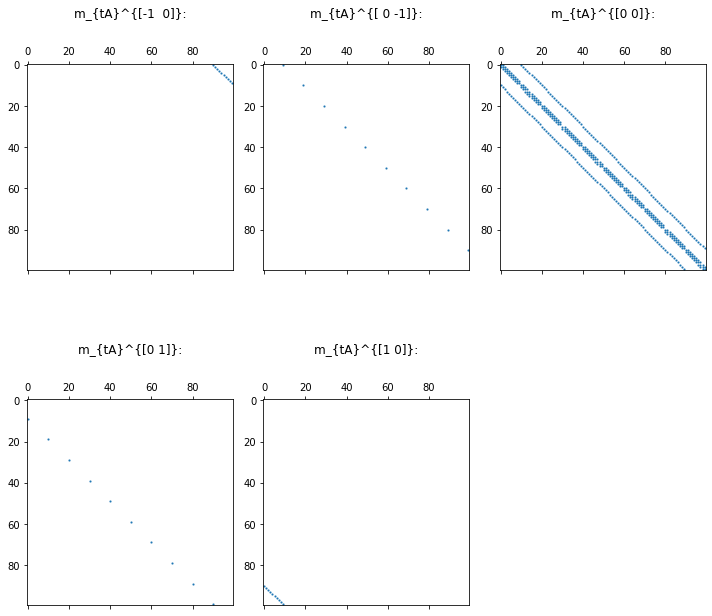

In [9]:
plt.figure(figsize=(10, 10))
for i in [0, 1, 2, 3, 4]:
    plt.subplot(231 + i)
    plt.spy(tA.m[i].matrix, markersize=1)
    plt.title("m_{tA}^{" + str(tA.m[i].pos) + "}:")
    plt.gca().title.set_position([.5, 1.2])

plt.tight_layout()

### Step two
As we impose periodic boundary conditions on the unit square, all lattice points of $\mathbb{L}(Z)$ are identified. Thus, we obtain the system matrix $A$ by adding all multipliers of tA.


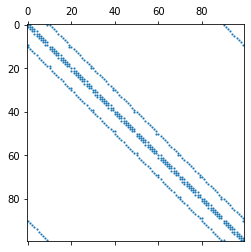

In [10]:
plt.figure()
A_matrix = sparse.csr_matrix(sum([x.matrix for x in tA.m]))
plt.spy(A_matrix, markersize=1)

## A link between the the eigenvalues of $A$ and $L_k$

We can compute the eigenvalues and eigenvectors of $A$ and compare them with the eigenvalues computed via LFA (saved in ````L_opcomp.df````)

Text(0.5, 1.0, 'Eigenvalues of L_k')

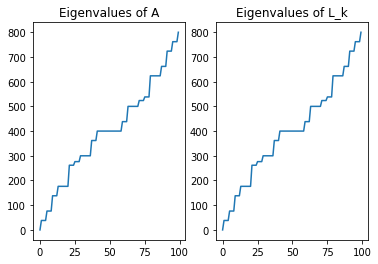

In [11]:
w, v = np.linalg.eig(A_matrix.todense())  # w = eigenvalues, v = eigenvectors.

# sorting eigenvalues and corresponding eigenvectors
w = np.real(w)  # eigenvalues and vectors are real due to A being symmetric
v = np.real(v)

ind = np.argsort(w)
w = w[ind]
v = v[:, ind]

plt.figure()
plt.subplot(121)
plt.plot(np.sort(np.real(w)))
plt.title('Eigenvalues of A')

plt.subplot(122)
plt.plot(np.sort(np.real(L_opcomp.df['eig_0'].values)))
plt.title('Eigenvalues of L_k')

The eigenvalues are equal as long as N=1/h, where $h$ corresponds to the lattice spacing and $N$ corresponds to the discretization of the frequency space. 

## A link between the the eigenvectors of $A$ and $L_k$

We take a look at the corresponding eigenvectors v and draw the connection to the spectral plot of $L_k$, $k \in \mathcal{A}^{-T}[0,1)^2$.

An eigenvector v[:,i] corresponds to the eigenvalue w[i]. Herein, each value v[j,i] corresponds to the value at position "tA.C.s[0][j]". We use this to create a 3d plot of the eigenvectors.

From the system matrix we obtain eigenvectors v[:,i] corresponding to eigenvalue w[i]. We find the same eigenvalue from the symbol of $L_k$ for some $k \in \mathcal{A}^{-T}[0,1)^2$. The eigenvector v[:,i] is a linear combinations of the wavefunctions $$e^{2 \pi i \langle k , x \rangle} \in \{e^{2 \pi i \langle k , x \rangle} \ :k \in \mathcal{A}^{-T}[0,1)^2 : \operatorname{spec}(L_k) = w[i] \}.$$


Execute the following cell. You should see a slider which you can move stepwise to choose $i$.
On the left hand side you see a plot of an eigenvector v[:,i]. On the right hand side the corresponding wavevectors k are marked. v[:,i] is a linear combination of the wavefunctions corresponding to the marked wavevecors k.

You should see that small eigenvalues correspond to smooth functions (marked wavevector "k" are  found in the corner of the primitive cell $\mathcal{A}^{-T}[0,1)^2$), whereas large eigenvalues correspond to oscillating functions.



In [12]:
# creating an interactive plot with ipywidgets.

from ipywidgets import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

# defining the plot function in dependence of the value of the slider i.


def update(i=0):
    # plotting eigenvector corresponding to eigenvalue w[i].

    x = tA.C.s[0].T[0]  # x value of the structure element
    y = tA.C.s[0].T[1]  # y value of the structure element
    z = v[:, i]  # The eigenvector

    # reshape is needed for the surface plot.
    M = np.int(np.round(1/h))
    x = x.reshape(M, M)
    y = y.reshape(M, M)
    z = z.reshape(M, M)

    # creating the 3d plot of the wavevector.
    plt.figure(figsize=(20, 10))
    ax_eigenvector = plt.subplot(121, projection='3d')
    ax_eigenvector.plot_surface(x, y, np.real(z), cmap=mpl.cm.viridis)
    plt.title('Eigenvector corresponding to eigenvalue ' +
              str(np.round(w[i])) + ':')
    plt.gca().title.set_position([.5, 1.1])

    # plotting the frequency space
    ax_freqspace = plt.subplot(122)
    plt.gcf()
    # plot of the spectrum of L_k , k in A^{-T}[0,1)^2.
    L_opcomp.plot_spectrum()

    # scatter plot of all wavevectors k
    plt.scatter(L_opcomp.df['dAk_0'].values, L_opcomp.df['dAk_1'].values)

    # find and mark the wavevectors k which correspond to the current eigenvalue w[i]
    k_ind_set = np.argwhere(np.abs((L_opcomp.df['eig_0']) - w[i]) < 1e-13)
    for k_ind in k_ind_set:
        k_1 = L_opcomp.df['dAk_0'][k_ind]
        k_2 = L_opcomp.df['dAk_1'][k_ind]
        plt.plot(k_1, k_2, marker='o', markersize=20,
                 markerfacecolor='lightgrey')
    plt.tight_layout()


# define slider widget
interact(update, i=widgets.IntSlider(
    min=0, max=w.shape[0]-1, step=1, value=3, continuous_update=False))

interactive(children=(IntSlider(value=3, continuous_update=False, description='i', max=99), Output()), _dom_cl…

<function __main__.update(i=0)>

# Definition of the Jacobi-method

Given a linear system of equations (LSE) $Ax=b$, the Jacobi method produces iterates via
$$x_{k+1} \leftarrow (I-S^{-1}A)x_k + S^{-1}b,$$
where $I$ is the identity and $S$ is simply the diagonal of $A$.


Denote with $x^* = A^{-1}b$ the solution of the LSE and with $e_k = x^* - x_k$ the $k$th error. Since
$$e_{k+1} = (I-S^{-1}A)e_k$$
the operator $G:=(I-S^{-1}A)$ is called error propagator. We are interested in the spectral radius $\rho(G) = \max\{|\lambda |  \ : \ \lambda \text{ Eigenvalue of $G$} \}$ of the error propagator, as we have 
$$||e_{k+1}|| \approx \rho(G) ||e_{k}||$$ for large k (if the initial error has a component in the direction of the eigenvector corresponding to the largest absolute eigenvalue).

We compute the spectrum via LFA, thus we need to define $I$ and $S$ as multiplication operators.
The nonzero multipliers of the operator $$S:\mathcal{L}(\mathbb{L}^s(\mathcal{A})) \rightarrow \mathcal{L}(\mathbb{L}^s(\mathcal{A})), \quad\quad \quad (Sf)(x) = \sum_{y \in \mathbb{Z}^\text{d}  } m_S^{y} \cdot f(x+\mathcal{A}y),$$
are given by $$m_S^{y} = \begin{cases} m_L^{y}  & \text{ if } y = 0 \\ 0 & \text{ else.} \end{cases} $$

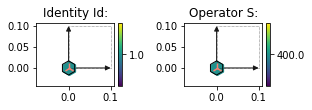

In [13]:
Id = alfa.tools.identity(C)  # the identity operator on the crystal C

# defines the an operator with the same domain and codomain as L. The only non-zero multiplier is m_L^{0}.
Sjac = alfa.tools.central_multiplier_of(L)

# plot
plt.figure()
plt.subplot(131)
Id.plot()
plt.title('Identity Id:')

plt.subplot(132)
Sjac.plot()
plt.title('Operator S:')
plt.tight_layout()

# Analysis of the Jacobi method.

We analyze the error propagator of the Jacobi method using underrelaxation of .8.

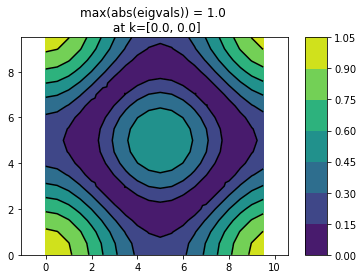

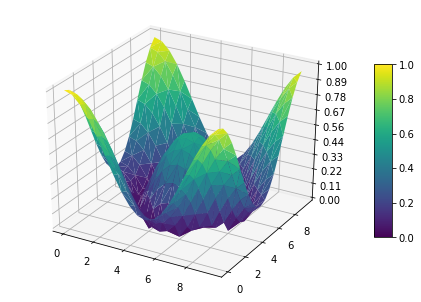

In [14]:
# matrices are saved as 2d numpy arrays.
# "@" denotes the matrix multiplication operator 'matmul' https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html#numpy.matmul
# pinv() corresponds to the moore-penrose pseudoinverse: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html
Gjac_dict = {'I': Id, 'Sjac': Sjac, 'L': L}
Gjac_str = "('I' - 0.8*pinv('Sjac')@'L')"
Gjac = alfa.Operator_Composition(Gjac_dict, Gjac_str)

Gjac.discretize_frequency_space(20)
Gjac.compute_spectrum()

plt.figure()
Gjac.plot_spectrum()
plt.figure()
Gjac.plot_spectrum_3d()

# Definition of the two-grid error propagator

We are going to analyze the two-grid method corresponding to the error propagator
$KG_1 = (I-P L_c^{-1} RL)\cdot G_1$ with $R=P^T$, $L_c = RLP$. Thus, we only have to define the prolongation operator $P$ explicitly. This operator maps from a coarse crystal to the fine crystal $\mathbb{L}^s(\mathcal{A})$.

We use the following coarse grid: $\mathbb{L}^{t}(2\mathcal{A})$, $t=(0,0)$:

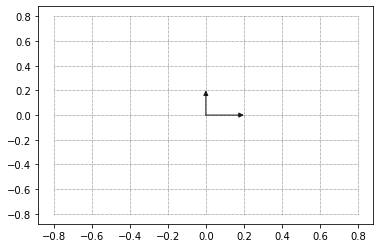

In [15]:
alfa.Lattice(2*A).plot_lattice()

The so-called 'full weighting' prolongation operator $P$ has a translational invariance of $2\mathcal{A}$. Thus we can define it within this framework as
$$P : \mathcal{L}(\mathbb{L}^t(2\mathcal{A})) \rightarrow \mathcal{L}(\mathbb{L}^{\hat{s}}(2\mathcal{A})),$$

where the codomain $\mathbb{L}^{\hat{s}}(2\mathcal{A})$ is a representation of the fine crystal $\mathbb{L}^{s}(\mathcal{A})$, but with respect to the larger translational invariance. This is the case if the structure element consists of all lattice points $\mathbb{L}(\mathcal{A})$ found in the primitive cell $2\mathcal{A}[0,1)^2$:  $$\hat{s} = \mathbb{L}^s(\mathcal{A}) \cap 2\mathcal{A}[0,1)^2 =  ( s, s + \mathcal{a}_1, s + \mathcal{a}_2, s + \mathcal{a}_1 + \mathcal{a}_2) = ( 0,  \mathcal{a}_1,  \mathcal{a}_2,  \mathcal{a}_1 + \mathcal{a}_2).$$



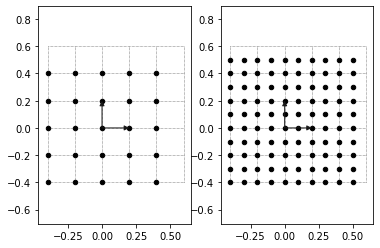

In [16]:
p_domain = np.asarray([[0, 0]])  # corresponds to "t" in the above description
# corresponds to \hat{s} in the above description
p_codomain = np.asarray([A@[0, 0], A@[0, 1], A@[1, 0], A@[1, 1]])


Ccoarse = alfa.Crystal(2*A, [p_domain, p_codomain])

# a plot of the domain and codomain.
Ccoarse.plot_crystal()

We initialize and define the prolongation operator $P$. This operator maps a value of each coarse grid point to its $9$ nearest fine-grid points:

Text(0.5, 1.0, 'P:')

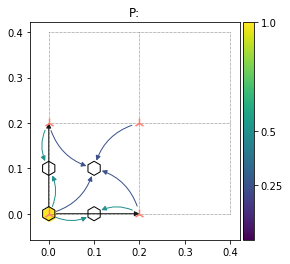

In [17]:
P = alfa.Operator(Ccoarse)
P.add_multiplier(np.asarray(
    [[1], [1 / 2], [1 / 2], [1 / 4]]), np.asarray([0, 0]))
P.add_multiplier(np.asarray([[0], [0], [1/2], [1/4]]), np.asarray([1, 0]))
P.add_multiplier(np.asarray([[0], [1/2], [0], [1/4]]), np.asarray([0, 1]))
P.add_multiplier(np.asarray([[0], [0], [0], [1/4]]), np.asarray([1, 1]))
P.plot()
plt.title("P:")

We can compute the restriction operator $R=P^T$ and the coarse grid operator $L_c = RLP$.

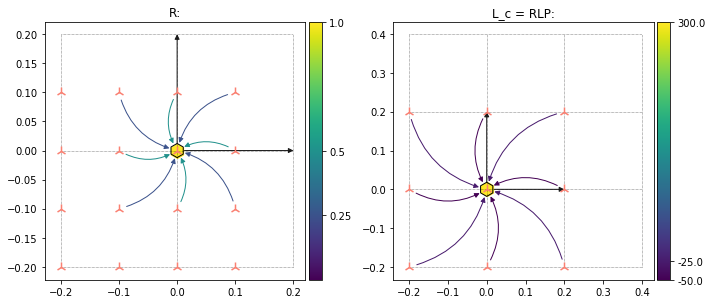

In [18]:
R = P.transpose()
# "@" denotes the multiplication operator for operators. In here, Algorithm B.5 of aLFA_Article is used.
Lc = R@L@P

plt.figure(figsize=(10, 10))
plt.subplot(121)
R.plot()
plt.title("R:")

plt.subplot(122)
Lc.plot()
plt.title("L_c = RLP:")
plt.tight_layout()

# Two-grid analysis with Jacobi smoothing:

As all operators share the translational invariance of $\mathbb{L}(2\mathcal{A})$ each operator can be rewritten with respect to this translational invariance. Alltogether, the error propagator is a mapping 
$$KG_1 : \mathcal{L}(\mathbb{L}^{\hat{s}}(2\mathcal{A})) \rightarrow \mathcal{L}(\mathbb{L}^{\hat{s}}(2\mathcal{A})).$$
As the structure element is of size $4$ ( $\hat{s} = ( 0,  \mathcal{a}_1,  \mathcal{a}_2,  \mathcal{a}_1 + \mathcal{a}_2)$), its symbol $(KG_1)_k$ is of size $4\times 4$ and we obtain $4$ eigenvalues per wavevector $k$.


   k_0       k_1  dAk_0     dAk_1                         eig_0  \
0  0.0  0.000000    0.0  0.000000                (1.7520833+0j)   
1  0.0  0.047619    0.0  0.238095  (-0.59553236+2.2923186e-16j)   

                        eig_1                       eig_2  \
0                   (-0.6+0j)                    (0.2+0j)   
1  (0.20888545-5.103937e-16j)  (0.19553234+7.436226e-17j)   

                           eig_3  
0                       (0.2+0j)  
1  (-5.187429e-15+6.645648e-16j)  


/home/wmaisrv1/kintsche/miniconda3/envs/alfa/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


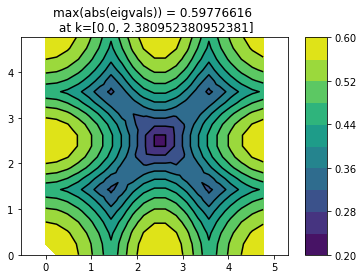

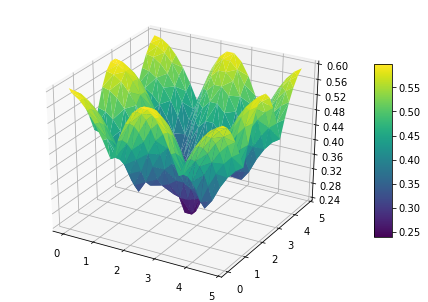

In [19]:
omega = .8  # relaxation parameter

CGC = {'P': P, 'Lc': Lc, 'R': R}
Twogrid_jac = {**Gjac_dict, **CGC}  # joining the two dictionaries

Gjac_str = "('I' - " + str(omega) + "*pinv('Sjac')@'L')"
CGC_str = "('I'-'P'@pinv('Lc')@'R'@'L')"


twogrid = alfa.Operator_Composition(Twogrid_jac,  CGC_str + "@" + Gjac_str)

twogrid.discretize_frequency_space(21)
twogrid.compute_spectrum()

# printing some rows of the dataframe. For each wavevector we have 4 eigenvalues.
print(twogrid.df.iloc[0:2])


# the constant function exp(2pi*k'*x) corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid._df.at[0, 'eig_0'] = None


# a plot of the spectral radius, that is abs(twogrid.df['eig_0']) with respect to twogrid.df['dAk'].
plt.figure()
twogrid.plot_spectrum()
plt.figure()
twogrid.plot_spectrum_3d()

The spectral radius of the two-grid error propagator is $.6$ when we use underrelaxation of $\omega = .8$ in the Jacobi-method. Thus, the norm of an error is reduced by $40\%$ in each iteration of the two-grid method. 

# Changing the smoother: lexicographic Gauss-Seidel

Given a linear system of equations (LSE) $Ax=b$, the Gauss-Seidel method produces iterates via
$$x_{k+1} \leftarrow (I-S^{-1}A)x_k + S^{-1}b,$$
where $I$ is the identity and $S$ is simply the triangle of $A$. 
We assume that the unknowns $x_1,x_2,\ldots,x_{1/h^2}$ are ordered lexicographically, i.e., $$x_i=(x_{i_1}, x_{i_2}) < x_j=(x_{j_1}, x_{j_2}) \text{ iff } \left[(x_{i_1} < x_{j_1}) \text{ or } (x_{i_1} = x_{j_1} \text{ and }x_{i_2} < x_{j_2})\right].$$

In the lower triangle of $A$ we find the connections of each unknown $x_i$, which is not part of the boundary, to the unknowns $x_j$ with $x_i \leq x_j$. Thus, we can express this operator for all unknowns that do not lie at the boundary. We have

 $$S:\mathcal{L}(\mathbb{L}^s(\mathcal{A})) \rightarrow \mathcal{L}(\mathbb{L}^s(\mathcal{A})), \quad\quad \quad (Sf)(x) = \sum_{y \in \mathbb{Z}^\text{d}  } m_S^{y} \cdot f(x+\mathcal{A}y) \quad \text{ for all $x$ which do not lie near/at the boundary} ,$$
with nonzero multipliers $$m_S^{y} = \begin{cases} m_L^{y}  & \text{ if } y \leq 0 \\ 0 & \text{ else} \end{cases} $$
where $y \leq 0$ refers to the lexicographic ordering. 


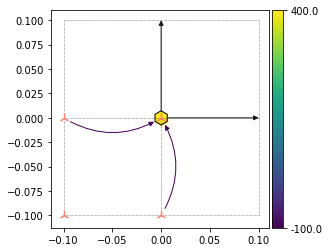

In [20]:
# help(alfa.tools.lower_triangle_of) # uncomment to inspect the corresponding documentation
Sgs = alfa.tools.lower_triangle_of(L)

Sgs.plot()

We take a look at the difference of this representation with the actual lower triangle of the matrix $A$. The differences only relate to unknowns at the boundary:

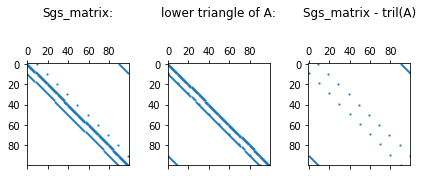

In [21]:
Sgs_op = Sgs.wrt_lattice(alfa.Lattice(np.eye(2)))
Sgs_op.normalize()

Sgs_matrix = sparse.csr_matrix(sum([x.matrix for x in Sgs_op.m]))

plt.figure()
plt.subplot(131)
plt.spy(Sgs_matrix, markersize=1)
plt.title("Sgs_matrix:")
plt.gca().title.set_position([.5, 1.4])

plt.subplot(132)
# plot of the lower triangle of A:
plt.spy(np.tril(A_matrix.todense()), markersize=1)
plt.title("lower triangle of A:")
plt.gca().title.set_position([.5, 1.4])

plt.subplot(133)
# difference of these two matrices:
plt.spy(Sgs_matrix - np.tril(A_matrix.todense()), markersize=1)
plt.title("Sgs_matrix - tril(A)")
plt.gca().title.set_position([.5, 1.4])
plt.tight_layout()

## Two-grid analysis with lexicographic Gauss-Seidel smoothing:

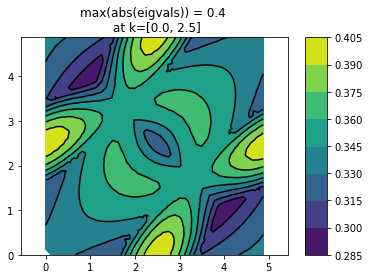

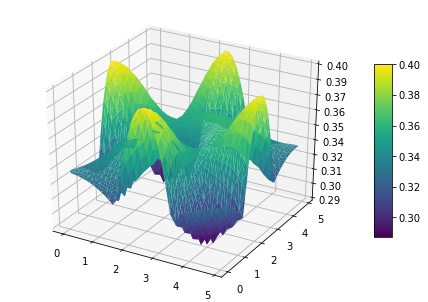

In [22]:
Twogrid_gs = {**Twogrid_jac, **{'Sgs': Sgs}}
Ggs_str = "('I' - pinv('Sgs')@'L')"

twogrid_gs = alfa.Operator_Composition(Twogrid_gs, CGC_str + "@" + Ggs_str)

twogrid_gs.discretize_frequency_space(40)
twogrid_gs.compute_spectrum()

# the constant function exp(2pi*k'*x) corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_gs._df.at[0, 'eig_0'] = None

plt.figure()
twogrid_gs.plot_spectrum()
plt.figure()
twogrid_gs.plot_spectrum_3d()

# A colored smoother: red-black Gauss-Seidel

Instead of lexicographic Gauss-Seidel, we can update unknowns using a different ordering. Consider the following red-black coloring of the underlying structure:

![title](figs/red-black.gif)


Red-black Gauss-Seidel corresponds to the method which updates red unknowns before it updates black unknowns. This can be described with an error propagator of the form
$G_b \cdot G_r$ where $G_x=(I - R_x^T (R_x A R_x^{T})^{-1}R_x A)$, where $R_x$, $x=r,b$, is the canonical restriction to the red/black unknowns.

First, we describe the red-black crystal:
We have $$\mathbb{L}^u(C), C = \left(\begin{matrix} \mathcal{a}_1 + \mathcal{a}_2 & \mathcal{a}_1 - \mathcal{a}_2 \end{matrix}\right) = \mathcal{A}\left(\begin{matrix} 1 & 1 \\ 1 & -1\end{matrix}\right)$$
with $u=(0,\mathcal{a}_1)=:(u_\text{red} , u_\text{black})$. 


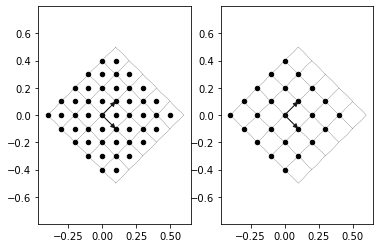

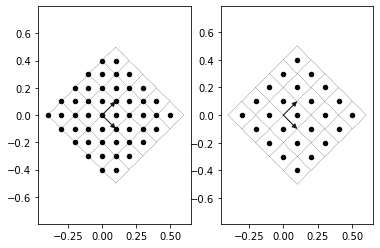

In [23]:
C = A@[[1, 1], [1, -1]]
u = np.asarray([A@[0, 0], A@[1, 0]])
u_red = np.asarray([A@[0, 0]])
u_black = np.asarray([A@[1, 0]])

Cr = alfa.Crystal(C, [u, u_red])
Cb = alfa.Crystal(C, [u, u_black])

# plots of the crystals Cr and Cb

# on the left hand side the domain of the Restriction operator R_x is depicted,
# on the right the codomain of the restriction oeprator R_x is depicted, Top: "red" point, Bottom: "black" points
plt.figure()
Cr.plot_crystal()
plt.figure()
Cb.plot_crystal()

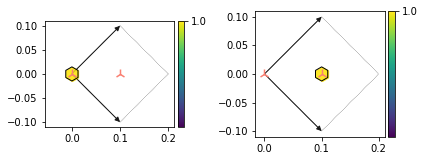

In [24]:
# we define the restriction operators

R_r = alfa.Operator(Cr)
R_r.add_multiplier(np.asarray([[1, 0]]), np.asarray([0, 0]))

R_b = alfa.Operator(Cb)
R_b.add_multiplier(np.asarray([[0, 1]]), np.asarray([0, 0]))


plt.figure()
plt.subplot(121)
R_r.plot()

plt.subplot(122)
R_b.plot()

plt.tight_layout()

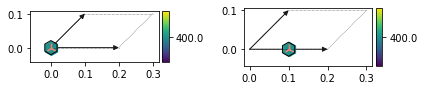

In [25]:
S_r = R_r@L@R_r.transpose()
S_b = R_b@L@R_b.transpose()


plt.figure()
plt.subplot(121)
S_r.plot()

plt.subplot(122)
S_b.plot()

plt.tight_layout()

Each unknown in the discretized Laplacian $L$ interacts with its $4$ nearest neighbors (+itself) only. Thus, besides to the connection to itself, a red (black) unknown is only connected to black (red) unknowns. As a result, on the matrix level, the restriction of $A$ to $A_x = R_x\cdot A\cdot R_x^T$, $x=r,b$, are simply diagonal matrices.

# Twogrid analysis with red-black smoothing

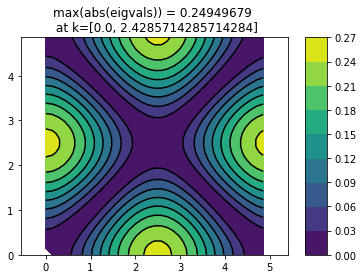

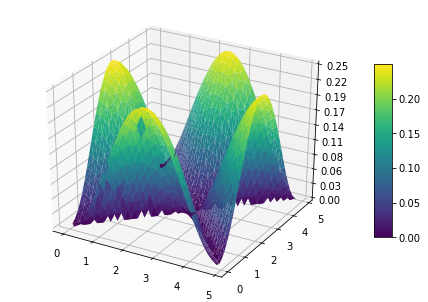

In [26]:
Grb = {'Rr': R_r, 'Sr': S_r, 'Rb': R_b, 'Sb': S_b}

Twogrid_rb = {**Twogrid_gs, **Grb}
Gr_str = "('I' - 'Rr'.transpose()@pinv('Sr')@'Rr'@'L')"
Gb_str = "('I' - 'Rb'.transpose()@pinv('Sb')@'Rb'@'L')"


twogrid_rb = alfa.Operator_Composition(
    Twogrid_rb, CGC_str + "@" + Gr_str+"@" + Gb_str)

twogrid_rb.discretize_frequency_space(35)
twogrid_rb.compute_spectrum()

# The constant function exp(2pi*k'*x) corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_rb._df.at[0, 'eig_0'] = None


plt.figure()
twogrid_rb.plot_spectrum()
plt.figure()
twogrid_rb.plot_spectrum_3d()

## Alternative construction and analysis of red-black

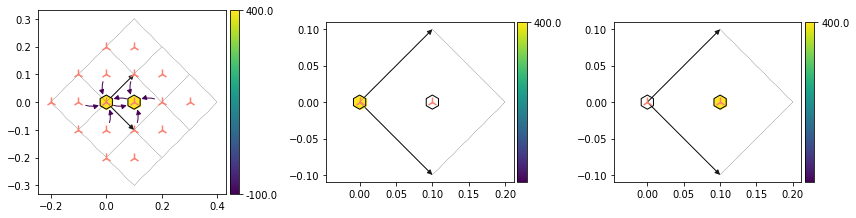

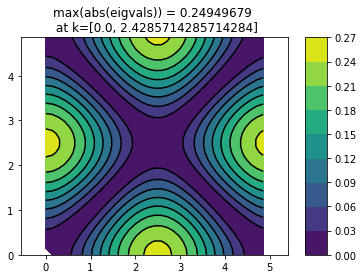

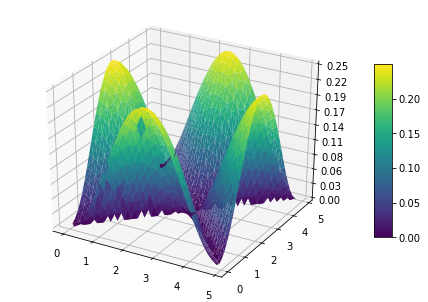

In [27]:
# 1. rewrite the Laplacian with respect to the translation invariance C
Lrb = L.wrt_lattice(alfa.Lattice(A@[[1, 1], [1, -1]]))


# plot of Lrb
plt.figure(figsize=(12, 12))
plt.subplot(131)
Lrb.plot()


# 2. subset selection of this operator

# help(alfa.tools.central_multiplier_of) # uncomment to inspect the corresponding documentation
S_r_alt = alfa.tools.central_multiplier_of(Lrb, [0])
S_b_alt = alfa.tools.central_multiplier_of(Lrb, [1])

# plot of both operators
plt.subplot(132)
S_r_alt.plot()
plt.subplot(133)
S_b_alt.plot()
plt.tight_layout()

# (I-(S_r_alt)^\dagger L) is equivalent to (I- R_r^T(R_r*S_r*R_r^T)^{-1}R_r L),
# where ^\dagger denotes the Moore-penrose pseudoinverse.

# 3. two-grid analysis
Twogrid_rb_alt = {**Twogrid_rb, **{'Sr_alt': S_r_alt, 'Sb_alt': S_b_alt}}

Gr_alt_str = "('I' - pinv('Sr_alt')@'L')"
Gb_alt_str = "('I' - pinv('Sb_alt')@'L')"


twogrid_rb_alt = alfa.Operator_Composition(
    Twogrid_rb_alt, CGC_str + "@" + Gr_alt_str + "@" + Gb_alt_str)

twogrid_rb_alt.discretize_frequency_space(35)
twogrid_rb_alt.compute_spectrum()

# the constant function exp(2pi*k'*x) corresponding to k=(0,0) is in the kernel of L. We ignore this eigenvalue.
twogrid_rb_alt._df.at[0, 'eig_0'] = None


plt.figure()
twogrid_rb_alt.plot_spectrum()
plt.figure()
twogrid_rb_alt.plot_spectrum_3d()

# Prototyping a two-grid method

By rewriting all operators with respect to a shared *large* translationally invariance $\mathcal{Z}$ analogously to "[Obtaining a system matrix $A$ from a multiplication operator $L$](#Obtaining-a-system-matrix-$A$-from-a-multiplication-operator-$L$)", we can prototype a two-grid method as follows. We stick to the Jacobi example.

In [28]:
# recall that we have saved all necessary operators in the dictionary Twogrid_jac

Twogrid_jac_prototype = {x: Twogrid_jac[x].wrt_lattice(
    alfa.Lattice(np.eye(2))) for x in Twogrid_jac}
for key in Twogrid_jac:
    # normalize structure elements, i.e., shift into Z[0,1)^2 and sort lexicographically.
    Twogrid_jac_prototype[key].normalize()
    # create matrices by summing up all multipliers (We have periodic boundary conditions)
    Twogrid_jac_prototype[key] = sparse.csc_matrix(
        sum([x.matrix for x in Twogrid_jac_prototype[key].m]))

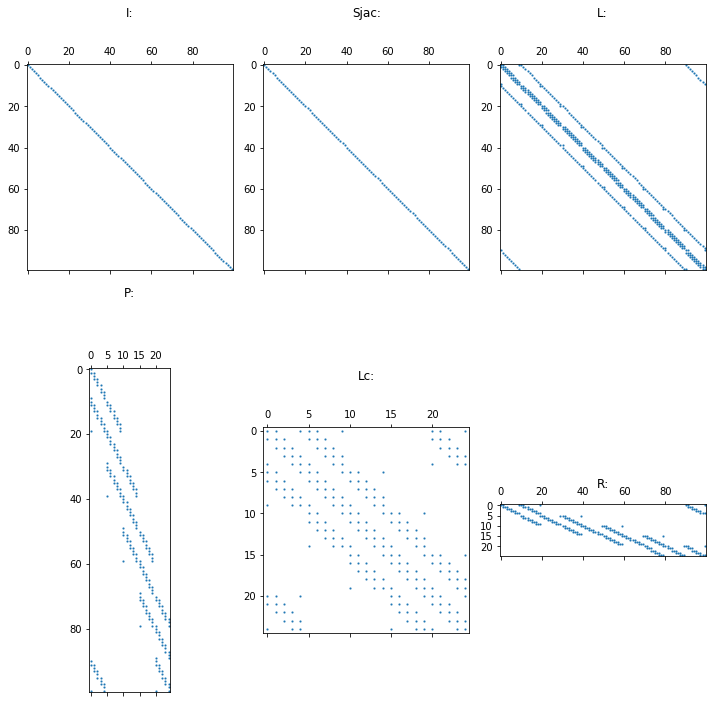

In [29]:
# create spy plot of all operators.
plt.figure(figsize=(10, 10))

# for j,y in enumerate(Ymat):
for j, key in enumerate(Twogrid_jac):
    plt.subplot(230 + 1 + j)
    plt.spy(Twogrid_jac_prototype[key], markersize=1)
    plt.title(key + ":")
    plt.gca().title.set_position([.5, 1.2])

plt.tight_layout()

In [30]:
# definition of the iterative update schemes within the two-grid method.

from scipy.sparse import linalg

# compute a sparse LU decompostion of S and L_c
S_mat_lu = linalg.splu(Twogrid_jac_prototype['Sjac'])
Lc_mat_lu = linalg.splu(Twogrid_jac_prototype['Lc'])

# definition of the smoothing,
omega = .8  # relaxation parameter


def smooth(b, x):
    r = b-(Twogrid_jac_prototype['L']@x)  # compute the residual
    x += omega*S_mat_lu.solve(r)  # compute and add the correction
    return x

# definition of the coarse grid correction.


def cgc(b, x):
    r = b-(Twogrid_jac_prototype['L']@x)  # compute the residual
    r_c = Twogrid_jac_prototype['R']@r  # restrict to coarse grid
    x_c = Lc_mat_lu.solve(r_c)  # solve coarse grid problem
    # prolongate to fine grid and add to current iterate.
    x += Twogrid_jac_prototype['P']@x_c
    return x

The measured asymptotic convergence rate is: 0.6000638315034252


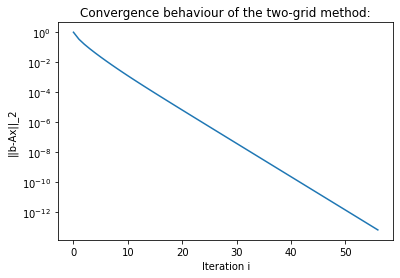

In [31]:
# running the two-grid method
n = Twogrid_jac_prototype['L'].shape[0]
# initialize right hand side and initial guess.
x = np.zeros(n, dtype='complex128')  # create initial guess 0
# create random initial guess which is not in the kernel of L
b = np.asarray(Twogrid_jac_prototype['L']@
               np.random.rand(n), dtype='complex128')
b = b/np.linalg.norm(b)  # normalize the right hand side.

it = 0
# define some lists where we save the convergence behaviour
resnorm_vec = [1]  # list of the norms of the residuals ||b-Ax_i||
# list of the current convergence rate rho_i = ||b-Ax_{i+1}|| / ||b-Ax_{i}|| <=>  ||b-Ax_{i+1}||  = rho_i ||b-Ax_{i}||
casym_vec = [1]

# the two-grid cycle
while np.linalg.norm(b - Twogrid_jac_prototype['L']@x) > 1e-13 and it < 150:
    it += 1
    x = smooth(b, x)  # smoothing step
    x = cgc(b, x)  # coarse grid correction

    # save data in each iterate
    resnorm_vec.append(np.linalg.norm(b - Twogrid_jac_prototype['L']@x))
    casym_vec.append(resnorm_vec[-1] / resnorm_vec[-2])


plt.figure()
plt.semilogy(resnorm_vec)
plt.xlabel('Iteration i')
plt.ylabel('||b-Ax||_2')
plt.title('Convergence behaviour of the two-grid method:')
print("The measured asymptotic convergence rate is:", casym_vec[-1])